In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('xente').getOrCreate()
spark

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
import catboost
from catboost import CatBoostClassifier, Pool
from pyod.models.lscp import LSCP
from pyod.models.knn import KNN

from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                              f1_score, precision_score, recall_score, roc_curve, roc_auc_score)
from pyspark.sql.functions import (mean, dayofmonth, hour, dayofweek,
                                                                   month, weekofyear, dayofyear,
                                                                   format_number, col, when)
from pyspark.ml.feature import Normalizer

In [2]:
def read_data_from_web(url):
  data = pd.read_csv(url)
  spark_data = spark.createDataFrame(data)
  return spark_data

#fraud_data = spark.read.csv('training.csv', header=True, inferSchema=True)
fraud_data = read_data_from_web("https://drive.google.com/uc?export=download&id=1NrtVkKv8n_g27w5elq9HWZA1i8aFBW0G")
df_backup = fraud_data

In [15]:
fraud_data = df_backup

### Engenharia de features

In [16]:
def remove_feature(data, columns_in):
  return data.drop(*columns_in)

def clean_data(fraud_data, columns_to_remove):
  fraud_data = remove_feature(fraud_data, columns_to_remove)
  return fraud_data

In [17]:
contamination = (fraud_data.filter('FraudResult==1').count())/(fraud_data.count())

In [18]:
avg_value = fraud_data.agg({'Value': 'avg'}).collect()[0][0]
fraud_data = fraud_data.withColumn('ValueStrategy',
        when(col('Value') > avg_value * 100, 3)
        .when(col('Value') > avg_value * 10, 2)
        .when(col('Value') > avg_value * 2, 1)
        .otherwise(0))

In [19]:
fraud_data.groupBy('ValueStrategy').count().show()

+-------------+-----+
|ValueStrategy|count|
+-------------+-----+
|            1| 6650|
|            3|  113|
|            2|  808|
|            0|88091|
+-------------+-----+



In [20]:
fraud_data = fraud_data.withColumn("Operation", when(fraud_data.Amount > 0, 1).when(fraud_data.Amount < 0, -1).otherwise(0))

fraud_data = fraud_data.withColumn('Hour', hour(fraud_data['TransactionStartTime']))
fraud_data = fraud_data.withColumn('DayOfWeek', dayofweek(fraud_data['TransactionStartTime']))
fraud_data = fraud_data.withColumn('DayOfYear', dayofyear(fraud_data['TransactionStartTime']))
fraud_data = fraud_data.withColumn('WeekOfYear', weekofyear(fraud_data['TransactionStartTime']))

fraud_data = fraud_data.withColumn('Vl_per_weekYr', (fraud_data['Value'] / fraud_data['WeekOfYear']))
fraud_data = fraud_data.withColumn('Vl_per_dayWk',  (fraud_data['Value'] / fraud_data['DayOfWeek']))
fraud_data = fraud_data.withColumn('Vl_per_dayYr',    (fraud_data['Value'] / fraud_data['DayOfYear']))

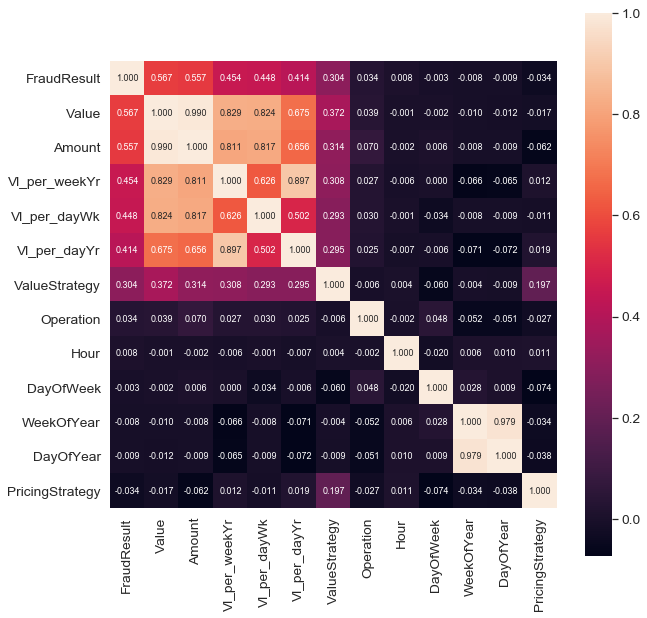

In [21]:
fraud_data_toCorr = fraud_data.toPandas()
corr_matrix = fraud_data_toCorr.corr()
k = 50 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'FraudResult')['FraudResult'].index
cm = np.corrcoef(fraud_data_toCorr[cols].values.T)
sns.set(font_scale=1.25,rc={'figure.figsize':(10, 10)})
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [22]:
fraud_data = clean_data(fraud_data, columns_to_remove = ['CurrencyCode','CountryCode','AccountId','SubscriptionId','CustomerId','TransactionStartTime','Amount','WeekOfYear'])

In [23]:
fraud_data.toPandas().columns

Index(['TransactionId', 'BatchId', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Value', 'PricingStrategy',
       'FraudResult', 'ValueStrategy', 'Operation', 'Hour', 'DayOfWeek',
       'DayOfYear', 'Vl_per_weekYr', 'Vl_per_dayWk', 'Vl_per_dayYr'],
      dtype='object')

In [24]:
all_features = ['TransactionId', 'BatchId', 'ProviderId', 'ProductId', 'ProductCategory',
               'ChannelId', 'Value', 'PricingStrategy', 'ValueStrategy',
               'Operation', 'Hour', 'DayOfWeek', 'DayOfYear', 
                'Vl_per_weekYr', 'Vl_per_dayWk', 'Vl_per_dayYr']

label = 'FraudResult'

categorical_features = ['TransactionId', 'BatchId', 'ProviderId', 'ProductId', 'ProductCategory',
       'ChannelId', 'PricingStrategy', 'Operation']

numerical_features = ['Value', 'ValueStrategy', 'Hour', 'DayOfWeek', 'DayOfYear',
                     'Vl_per_weekYr', 'Vl_per_dayWk', 'Vl_per_dayYr']

In [25]:
contamination

0.00201752001839811

### split data

In [26]:
fraud_data = fraud_data.toPandas()
X_train = fraud_data[all_features]
y_train = fraud_data[label]

In [27]:
X_outliers = fraud_data[fraud_data['FraudResult'].isin([1])]

In [28]:
X_train_toTrain = X_train[numerical_features]
X_outliers_toTrain = X_outliers[numerical_features]

### Isolation Forest

In [29]:
if_clf = IsolationForest(behaviour='new',random_state=42, contamination=contamination, n_jobs=12)

In [30]:
if_clf.fit(X_train_toTrain, y_train)

IsolationForest(behaviour='new', bootstrap=False,
                contamination=0.00201752001839811, max_features=1.0,
                max_samples='auto', n_estimators=100, n_jobs=12,
                random_state=42, verbose=0, warm_start=False)

In [31]:
predictions_if = if_clf.predict(X_train[numerical_features])

In [32]:
X_train_if = X_train
X_train_if['IsolationForest'] = predictions_if

In [33]:
X_train_if = X_train_if.replace({'IsolationForest' : 1}, 0)
X_train_if = X_train_if.replace({'IsolationForest' : -1}, 1)

### LSCP

In [34]:
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.cblof import CBLOF
from pyod.models.lof import LOF

detector_list = [FeatureBagging(contamination=contamination, 
                                combination='max', 
                                n_estimators=3, 
                                random_state=42, 
                                n_jobs=12), 
                             LOF(contamination=contamination, 
                                n_neighbors=3, 
                                n_jobs=12),
                             CBLOF(contamination=contamination, 
                                n_clusters=2, 
                                random_state=42, 
                                n_jobs=12)]

In [35]:
lscp_clf = LSCP(detector_list=detector_list, random_state=42, contamination=contamination)

In [36]:
lscp_clf.fit(X_train_toTrain)

/home/dunfrey/anaconda3/lib/python3.7/site-packages/pyod/models/lscp.py:371: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  "The number of histogram bins is greater than the number of "
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  0.5*df, 0.5, np.fmin(np.asarray(df / (df + t_squared)), 1.0)
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/dunfrey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3034: 

LSCP(contamination=0.00201752001839811,
   detector_list=[FeatureBagging(base_estimator=None, bootstrap_features=False,
        check_detector=True, check_estimator=False, combination='max',
        contamination=0.00201752001839811, estimator_params={},
        max_features=1.0, n_estimators=3, n_jobs=12, random_state=42,
        verbose=0)... contamination=0.00201752001839811, n_clusters=2, n_jobs=12,
   random_state=42, use_weights=False)],
   local_max_features=1.0, local_region_size=30, n_bins=3,
   random_state=<mtrand.RandomState object at 0x7fb587668ee8>)

In [37]:
predictions_lscp = lscp_clf.predict(X_train[numerical_features])

/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  0.5*df, 0.5, np.fmin(np.asarray(df / (df + t_squared)), 1.0)
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/dunfrey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3034: RuntimeWarning: Mean of empty slice.
  my = y.mean()


In [38]:
X_train_if_lscp = X_train_if
X_train_if_lscp['LSCP'] = predictions_lscp

### knn

In [39]:
knn_clf = KNN(n_jobs=12, contamination=contamination,n_neighbors=2,method='mean')

In [40]:
knn_clf.fit(X_train_toTrain, y_train)

/home/dunfrey/anaconda3/lib/python3.7/site-packages/pyod/models/base.py:344: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")


KNN(algorithm='auto', contamination=0.00201752001839811, leaf_size=30,
  method='mean', metric='minkowski', metric_params=None, n_jobs=12,
  n_neighbors=2, p=2, radius=1.0)

In [41]:
predictions_knn = knn_clf.predict(X_train[numerical_features])

In [42]:
X_train_if_lscp_knn = X_train_if_lscp
X_train_if_lscp_knn['Knn'] = predictions_knn

#### New Feature: CountDetection | PercentDetection

In [43]:
final_data = X_train_if_lscp_knn

In [44]:
final_data[ 'CountDetection'] = (final_data.IsolationForest + final_data.LSCP + final_data.Knn)

### Adding features to the dataframe

In [47]:
categorical_features.append('IsolationForest')
categorical_features.append('LSCP')
categorical_features.append('Knn')
categorical_features.append('CountDetection')

all_features.append('IsolationForest')
all_features.append('LSCP')
all_features.append('Knn')
all_features.append('CountDetection')

In [45]:
final_data.groupby('LSCP').count()

,TransactionId,BatchId,ProviderId,ProductId,ProductCategory,ChannelId,Value,PricingStrategy,ValueStrategy,Operation,Hour,DayOfWeek,DayOfYear,Vl_per_weekYr,Vl_per_dayWk,Vl_per_dayYr,IsolationForest,Knn,CountDetection
LSCP,,,,,,,,,,,,,,,,,,,
0,95484,95484,95484,95484,95484,95484,95484,95484,95484,95484,95484,95484,95484,95484,95484,95484,95484,95484,95484
1,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178


In [46]:
final_data.groupby('CountDetection').count()

,TransactionId,BatchId,ProviderId,ProductId,ProductCategory,ChannelId,Value,PricingStrategy,ValueStrategy,Operation,Hour,DayOfWeek,DayOfYear,Vl_per_weekYr,Vl_per_dayWk,Vl_per_dayYr,IsolationForest,LSCP,Knn
CountDetection,,,,,,,,,,,,,,,,,,,
0,95343,95343,95343,95343,95343,95343,95343,95343,95343,95343,95343,95343,95343,95343,95343,95343,95343,95343,95343
1,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203
2,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89
3,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27


In [48]:
categorical_features_dims = [final_data.columns.get_loc(i) for i in categorical_features[:]] 
numerical_features_dims = [final_data.columns.get_loc(i) for i in numerical_features[:]] 

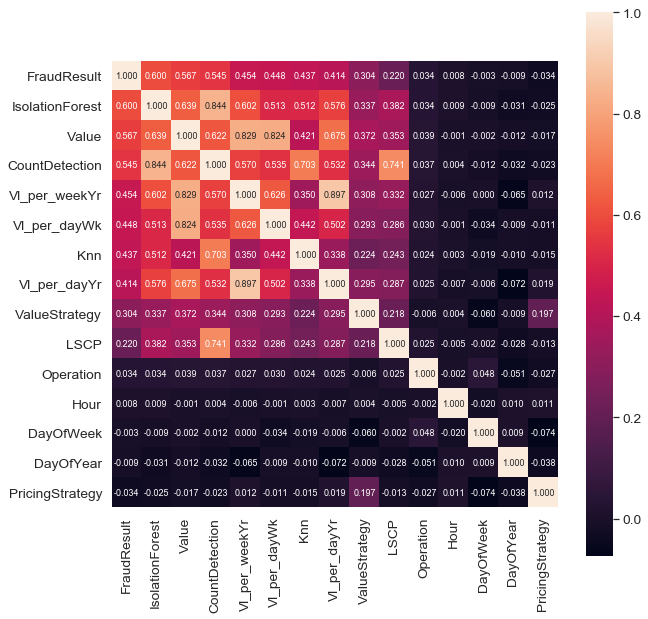

In [49]:
fraud_data_toCorr = final_data
fraud_data_toCorr['FraudResult'] = fraud_data[label]
corr_matrix = fraud_data_toCorr.corr()
k = 50 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'FraudResult')['FraudResult'].index
cm = np.corrcoef(fraud_data_toCorr[cols].values.T)
sns.set(font_scale=1.25,rc={'figure.figsize':(10, 10)})
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Balanceando

In [50]:
X_train = final_data[all_features]

In [51]:
sm = SMOTENC(categorical_features=categorical_features_dims, random_state = 42, n_jobs=12)

In [52]:
 X_smotenc, y_smotenc = sm.fit_resample(X_train, y_train)

In [53]:
X_smotenc = pd.DataFrame(X_smotenc, columns=all_features)
y_smotenc = pd.DataFrame(y_smotenc, columns=[label])

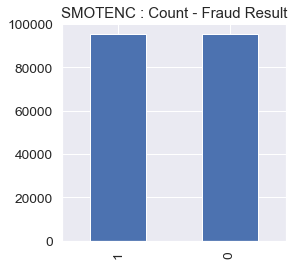

In [54]:
sns.set(font_scale=1.25,rc={'figure.figsize':(4, 4)})
pd.Series(y_smotenc[label]).value_counts().plot.bar(title='SMOTENC : Count - Fraud Result')

In [55]:
X_smotenc.columns

Index(['TransactionId', 'BatchId', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Value', 'PricingStrategy',
       'ValueStrategy', 'Operation', 'Hour', 'DayOfWeek', 'DayOfYear',
       'Vl_per_weekYr', 'Vl_per_dayWk', 'Vl_per_dayYr', 'IsolationForest',
       'LSCP', 'Knn', 'CountDetection'],
      dtype='object')

### CatBoost

In [56]:
model = CatBoostClassifier(eval_metric='F1',task_type="GPU",devices='0',random_seed=42)
model.fit(X_smotenc, y_smotenc, verbose=False, plot=True, cat_features=categorical_features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [57]:
shap.initjs()

shap_values = model.get_feature_importance(Pool(X_smotenc, y_smotenc, cat_features=categorical_features_dims), type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.force_plot(expected_value, shap_values[200,:], X_smotenc.iloc[200,:])

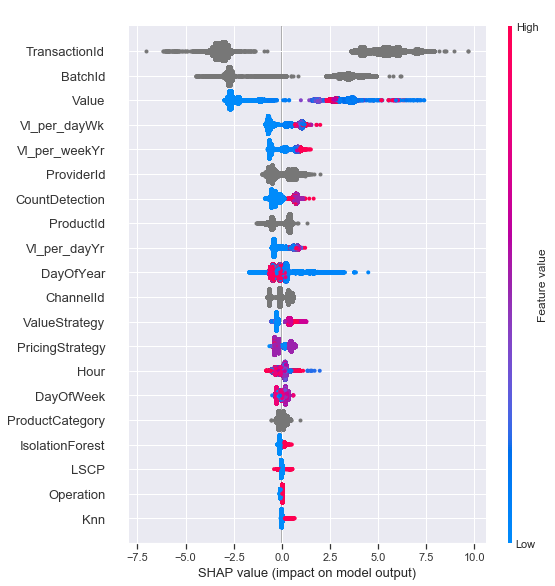

In [58]:
shap.initjs()
# summarize the effects of all the features
shap.summary_plot(shap_values, X_smotenc)

### Avaliacao

In [59]:
#test_data = read_data_from_web("https://drive.google.com/uc?export=download&id=16cRQIFW6n2th2YOK7DEsp9dQgihHDuHa")
test_data = spark.read.csv('../data/xente_fraud_detection_test.csv', header=True, inferSchema=True)
test_backup = test_data

In [60]:
avg_value = test_data.agg({'Value':'avg'}).collect()[0][0]
test_data = test_data.withColumn('ValueStrategy',
        when(col('Value') > avg_value * 100, 3)
        .when(col('Value') > avg_value * 10, 2)
        .when(col('Value') > avg_value * 2, 1)
        .otherwise(0))

In [61]:
test_data = test_data.withColumn("Operation", when(test_data.Amount > 0, 1).when(test_data.Amount < 0, -1).otherwise(0))

test_data = test_data.withColumn('Hour', hour(test_data['TransactionStartTime']))
test_data = test_data.withColumn('DayOfWeek', dayofweek(test_data['TransactionStartTime']))
test_data = test_data.withColumn('DayOfYear', dayofyear(test_data['TransactionStartTime']))
test_data = test_data.withColumn('WeekOfYear', weekofyear(test_data['TransactionStartTime']))

test_data = test_data.withColumn('Vl_per_weekYr', (test_data['Value'] / test_data['WeekOfYear']))
test_data = test_data.withColumn('Vl_per_dayWk',  (test_data['Value'] / test_data['DayOfWeek']))
test_data = test_data.withColumn('Vl_per_dayYr',    (test_data['Value'] / test_data['DayOfYear']))

In [62]:
test_data = clean_data(test_data, columns_to_remove = ['CurrencyCode','CountryCode','AccountId','SubscriptionId','CustomerId','TransactionStartTime','Amount','WeekOfYear'])

In [63]:
all_features = ['TransactionId', 'BatchId', 'ProviderId', 'ProductId', 'ProductCategory',
               'ChannelId', 'Value', 'PricingStrategy', 'ValueStrategy',
               'Operation', 'Hour', 'DayOfWeek', 'DayOfYear', 
                'Vl_per_weekYr', 'Vl_per_dayWk', 'Vl_per_dayYr']

label = 'FraudResult'

categorical_features = ['TransactionId', 'BatchId', 'ProviderId', 'ProductId', 'ProductCategory',
       'ChannelId', 'PricingStrategy', 'Operation']

numerical_features = ['Value', 'ValueStrategy', 'Hour', 'DayOfWeek', 'DayOfYear',
                     'Vl_per_weekYr', 'Vl_per_dayWk', 'Vl_per_dayYr']

In [64]:
test_data = test_data.toPandas()
X_test = test_data[all_features]

In [65]:
categorical_features_dims = [X_test.columns.get_loc(i) for i in categorical_features[:]] 
numerical_features_dims = [X_test.columns.get_loc(i) for i in numerical_features[:]] 

In [66]:
predictions_if = if_clf.predict(X_test[numerical_features])
X_test['IsolationForest'] = predictions_if

In [67]:
X_test = X_test.replace({'IsolationForest' : 1}, 0)
X_test = X_test.replace({'IsolationForest' : -1}, 1)

In [68]:
X_test_if = X_test

In [69]:
predictions_lscp = lscp_clf.predict(X_test[numerical_features])
X_test_if['LSCP'] = predictions_lscp

/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/dunfrey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3034: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/home/dunfrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  0.5*df, 0.5, np.fmin(np.asarray(df / (df + t_squared)), 1.0)


In [70]:
X_test_if_lscp = X_test_if

In [71]:
predictions_knn = knn_clf.predict(X_test[numerical_features])
X_test_if_lscp['Knn'] = predictions_knn

In [72]:
final_test_data = X_test_if_lscp

In [73]:
final_test_data[ 'CountDetection'] = (final_test_data.IsolationForest + final_test_data.LSCP + final_test_data.Knn)

In [74]:
final_result = model.predict( final_test_data )

In [75]:
def save_predictions_xente(file_name, transactions_list, predictions_list):
    file = open(file_name,'w')
    file.write('TransactionId,FraudResult\n')
    for (trans_id, value) in zip(transactions_list, predictions_list):
        file.write('{0},{1}\n'.format(trans_id, int(value)))
    file.close()

In [76]:
X_test = test_backup.toPandas()
output_file = 'xente_predictions.txt'  
X_test_transactions_list = list(X_test['TransactionId'])

In [77]:
save_predictions_xente(output_file, X_test_transactions_list, final_result)

In [78]:
print("Concluido")

Concluido
